In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [49]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [50]:
def smoothen(df, columns=[], N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_avg_df = df.copy().reset_index(drop=True)
    # An N-day rolling average with N/2 days before and N/2 after requires N+1
    # days to include the day of as well.
    rolling_avg_df[columns] = (
        rolling_avg_df[columns].rolling(N + 1, center=True).mean())
    return rolling_avg_df

def smoothen_within(df, columns=[], by=None, N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

In [51]:
home_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_df)
home_df = home_df[home_df['date_range_start'].dt.year.isin([2019, 2020])]
home_df = home_df.rename(columns={'home_cbg': 'cbg'})
home_df.head()

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
95,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360050001000,4,0.000000,0.333333,0.000000,0.000000
96,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470206001,4,9.790000,0.021739,0.021739,2.772665
97,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470435003,4,8.605042,0.016129,0.016129,2.437068
98,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470437001,4,11.749526,0.024390,0.024390,3.327630
99,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470573002,5,1.068101,0.005160,0.005160,0.302501


In [52]:
cdi_total_df = home_df.groupby(by=['date_range_start']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_total_df = cdi_total_df.sort_values(by=['date_range_start'])
cdi_total_df = smoothen(cdi_total_df, columns=['cdi'])
cdi_total_df.to_csv('./exports/cdi/total_all.csv', index=None)
cdi_total_df.head()

,date_range_start,cdi
0,2019-01-07 00:00:00-05:00,NaN
1,2019-01-14 00:00:00-05:00,NaN
2,2019-01-21 00:00:00-05:00,NaN
3,2019-01-28 00:00:00-05:00,354489.822830
4,2019-02-04 00:00:00-05:00,297742.549808


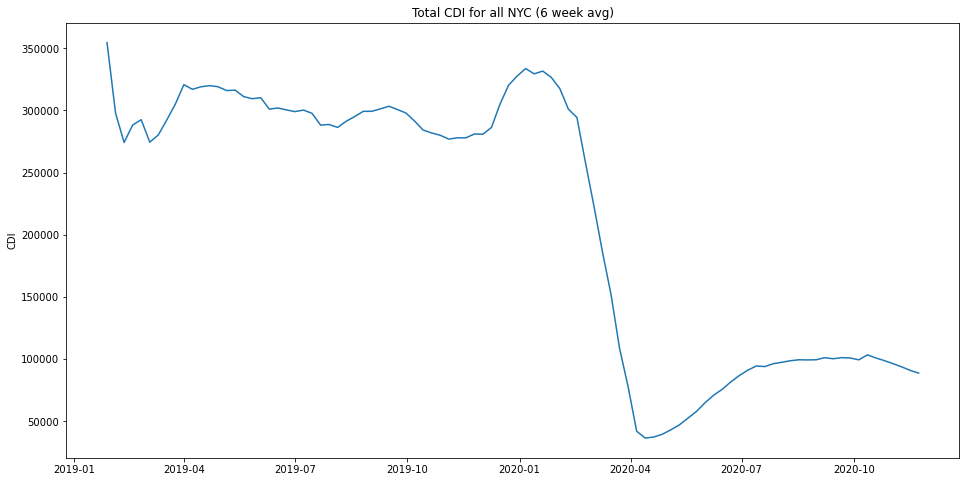

In [53]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(cdi_total_df['date_range_start'], cdi_total_df['cdi'])
ax.set_title('Total CDI for all NYC (6 week avg)')
ax.set_ylabel('CDI')
plt.show()

In [54]:
def create_diff_df(cdi_df, diff_columns=[], keep_columns=[]):
    cdi_week_df = cdi_df
    cdi_week_df['year'] = cdi_week_df['date_range_start'].dt.year
    cdi_week_df['week'] = cdi_week_df['date_range_start'].dt.week

    # Dates are missing from December 2020!
    display(cdi_week_df.iloc[95:105])

    cdi_2020_df = cdi_week_df[cdi_week_df['year'] == 2020]
    cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] >= 2]
    cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] <= 52].reset_index(drop=True)
    cdi_2019_df = cdi_week_df[cdi_week_df['year'] == 2019]
    cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] >= 2]
    # Remove dates that can't be compared.
    cdi_2019_df = cdi_2019_df[~cdi_2019_df['week'].isin(set([50, 51]))]
    cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] <= 52].reset_index(drop=True)

    display(cdi_2019_df.head())
    display(cdi_2020_df.head())

    cdi_diff_df = pd.DataFrame()
    for keep_column in (keep_columns + ['week', 'date_range_start']):
        cdi_diff_df[keep_column] = cdi_2020_df[keep_column]
    cdi_diff_df[diff_columns] = (cdi_2020_df[diff_columns] -
                                 cdi_2019_df[diff_columns])
    cdi_diff_df = cdi_diff_df.dropna()

    display(cdi_diff_df.head())

    return cdi_diff_df

In [55]:
cdi_diff_df = create_diff_df(cdi_total_df, diff_columns=['cdi'])
cdi_diff_df.to_csv('./exports/cdi/diff_all.csv', index=None)

,date_range_start,cdi,year,week
95,2020-11-02 00:00:00-05:00,96327.749791,2020,45
96,2020-11-09 00:00:00-05:00,93801.524761,2020,46
97,2020-11-16 00:00:00-05:00,90959.856651,2020,47
98,2020-11-23 00:00:00-05:00,88742.514781,2020,48
99,2020-11-30 00:00:00-05:00,NaN,2020,49
100,2020-12-21 00:00:00-05:00,NaN,2020,52
101,2020-12-28 00:00:00-05:00,NaN,2020,53


,date_range_start,cdi,year,week
0,2019-01-07 00:00:00-05:00,NaN,2019,2
1,2019-01-14 00:00:00-05:00,NaN,2019,3
2,2019-01-21 00:00:00-05:00,NaN,2019,4
3,2019-01-28 00:00:00-05:00,354489.822830,2019,5
4,2019-02-04 00:00:00-05:00,297742.549808,2019,6


,date_range_start,cdi,year,week
0,2020-01-06 00:00:00-05:00,333672.962395,2020,2
1,2020-01-13 00:00:00-05:00,329437.992095,2020,3
2,2020-01-20 00:00:00-05:00,331631.729179,2020,4
3,2020-01-27 00:00:00-05:00,326565.235334,2020,5
4,2020-02-03 00:00:00-05:00,317541.347102,2020,6


,week,date_range_start,cdi
3,5,2020-01-27 00:00:00-05:00,-27924.587496
4,6,2020-02-03 00:00:00-05:00,19798.797294
5,7,2020-02-10 00:00:00-05:00,26730.789975
6,8,2020-02-17 00:00:00-05:00,6089.153904
7,9,2020-02-24 00:00:00-05:00,-34540.763289


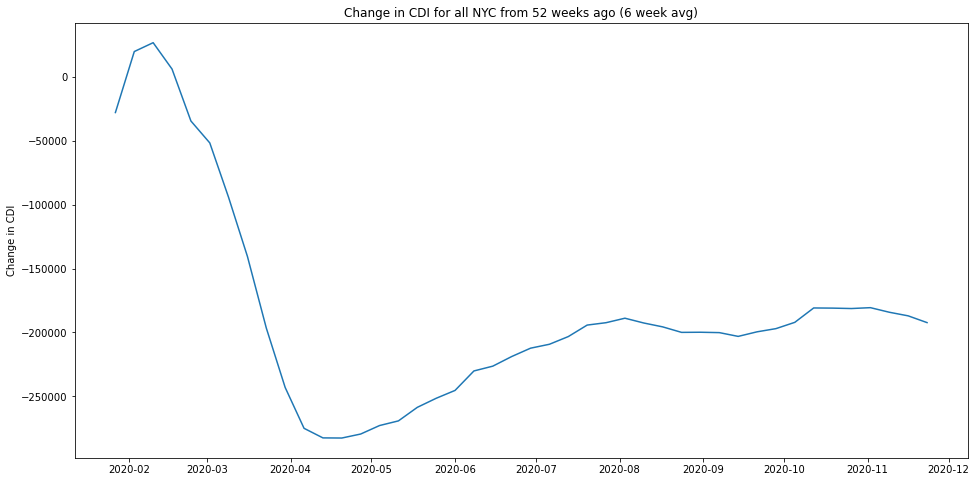

In [56]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(cdi_diff_df['date_range_start'], cdi_diff_df['cdi'])
ax.set_title('Change in CDI for all NYC from 52 weeks ago (6 week avg)')
ax.set_ylabel('Change in CDI')
plt.show()

In [64]:
#cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = pd.read_csv('./exports/proximity_clusters.csv')
#cbg_df = cbg_df.rename(columns={
#    'census_block_group': 'cbg',
#    'Cluster': 'cluster',
#    'Total Population': 'population',
#})
cbg_df = cbg_df[['cbg', 'cluster', 'population']]
cbg_df.head()

,cbg,cluster,population
0,360050001001,3,6864.0
1,360050002001,3,1744.0
2,360050002002,2,1569.0
3,360050002003,1,1219.0
4,360050004001,1,598.0


In [65]:
cluster_df = cbg_df.groupby(by=['cluster']).agg({
    'population': 'sum'
}).reset_index()
cluster_df

,cluster,population
0,0,937660.0
1,1,1639280.0
2,2,3615376.0
3,3,2224022.0


In [66]:
merge_df = home_df.merge(cbg_df, how='inner', on=['cbg'])
merge_df.head()

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population
0,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470206001,4,9.790000,0.021739,0.021739,2.772665,1,979.0
1,zzw-222@627-sb6-6ff,2019-05-20 00:00:00-04:00,360470206001,4,9.645320,0.022989,0.022989,1.067676,1,979.0
2,zzw-222@627-s86-5pv,2020-05-04 00:00:00-04:00,360470206001,4,13.053333,0.044444,0.044444,0.032604,1,979.0
3,222-223@627-wh5-n3q,2020-12-21 00:00:00-05:00,360470206001,4,16.453782,0.055556,0.055556,0.306294,1,979.0
4,22b-222@627-wgt-v75,2019-05-06 00:00:00-04:00,360470206001,4,9.458937,0.023392,0.023392,1.461888,1,979.0


In [75]:
cdi_cluster_df = merge_df.groupby(by=['date_range_start', 'cluster']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_cluster_df = cdi_cluster_df.merge(cluster_df, how='outer', on=['cluster'])
cdi_cluster_df = cdi_cluster_df.sort_values(by=['date_range_start', 'cluster'])
cdi_cluster_df[
    'cdi_per_capita'] = cdi_cluster_df['cdi'] / cdi_cluster_df['population']
cdi_cluster_df = smoothen_within(cdi_cluster_df,
                                 columns=['cdi', 'cdi_per_capita'],
                                 by='cluster')
#cdi_cluster_df.to_csv('./exports/cdi/total_by_cluster.csv', index=None)
cdi_cluster_df.head()

,date_range_start,cluster,cdi,population,cdi_per_capita
0,2019-01-07 00:00:00-05:00,0,NaN,937660.0,NaN
0,2019-01-07 00:00:00-05:00,1,NaN,1639280.0,NaN
0,2019-01-07 00:00:00-05:00,2,NaN,3615376.0,NaN
0,2019-01-07 00:00:00-05:00,3,NaN,2224022.0,NaN
1,2019-01-14 00:00:00-05:00,0,NaN,937660.0,NaN


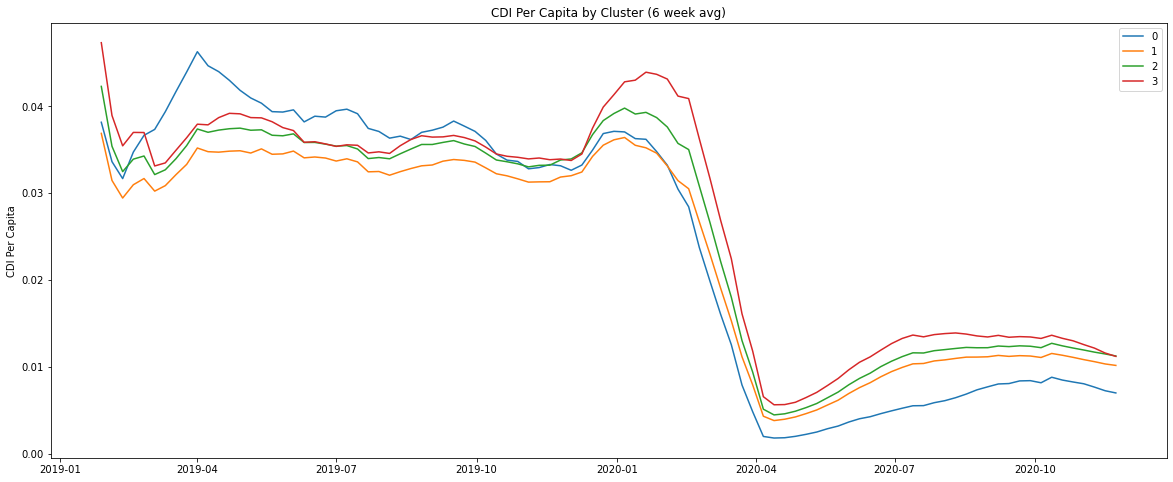

In [76]:
fig, ax = plt.subplots(figsize=(20, 8))
for key, group in cdi_cluster_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title('CDI Per Capita by Cluster (6 week avg)')
ax.set_ylabel('CDI Per Capita')
ax.legend()
plt.show()

In [77]:
cdi_cluster_diff_df = create_diff_df(cdi_cluster_df,
                                     diff_columns=['cdi', 'cdi_per_capita'],
                                     keep_columns=['cluster', 'cdi_per_capita'])
cdi_cluster_diff_df.to_csv('./exports/cdi/diff_by_cluster.csv', index=None)

,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
23,2019-06-17 00:00:00-04:00,3,79897.735888,2224022.0,0.035925,2019,25
24,2019-06-24 00:00:00-04:00,0,36347.125309,937660.0,0.038764,2019,26
24,2019-06-24 00:00:00-04:00,1,55812.968893,1639280.0,0.034047,2019,26
24,2019-06-24 00:00:00-04:00,2,128884.633495,3615376.0,0.035649,2019,26
24,2019-06-24 00:00:00-04:00,3,79337.290753,2224022.0,0.035673,2019,26
25,2019-07-01 00:00:00-04:00,0,37030.016970,937660.0,0.039492,2019,27
25,2019-07-01 00:00:00-04:00,1,55244.755980,1639280.0,0.033701,2019,27
25,2019-07-01 00:00:00-04:00,2,128046.557664,3615376.0,0.035417,2019,27
25,2019-07-01 00:00:00-04:00,3,78705.605998,2224022.0,0.035389,2019,27
26,2019-07-08 00:00:00-04:00,0,37201.589537,937660.0,0.039675,2019,28


,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
0,2019-01-07 00:00:00-05:00,0,NaN,937660.0,NaN,2019,2
1,2019-01-07 00:00:00-05:00,1,NaN,1639280.0,NaN,2019,2
2,2019-01-07 00:00:00-05:00,2,NaN,3615376.0,NaN,2019,2
3,2019-01-07 00:00:00-05:00,3,NaN,2224022.0,NaN,2019,2
4,2019-01-14 00:00:00-05:00,0,NaN,937660.0,NaN,2019,3


,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
0,2020-01-06 00:00:00-05:00,0,34745.966677,937660.0,0.037056,2020,2
1,2020-01-06 00:00:00-05:00,1,59691.917486,1639280.0,0.036413,2020,2
2,2020-01-06 00:00:00-05:00,2,143891.061340,3615376.0,0.039800,2020,2
3,2020-01-06 00:00:00-05:00,3,95248.077481,2224022.0,0.042827,2020,2
4,2020-01-13 00:00:00-05:00,0,34022.627908,937660.0,0.036285,2020,3


,cluster,cdi_per_capita,week,date_range_start,cdi
12,0,-0.003381,5,2020-01-27 00:00:00-05:00,-3170.472325
13,1,-0.002281,5,2020-01-27 00:00:00-05:00,-3738.871384
14,2,-0.003593,5,2020-01-27 00:00:00-05:00,-12991.851269
15,3,-0.003643,5,2020-01-27 00:00:00-05:00,-8102.273311
16,0,-0.000410,6,2020-02-03 00:00:00-05:00,-384.807805


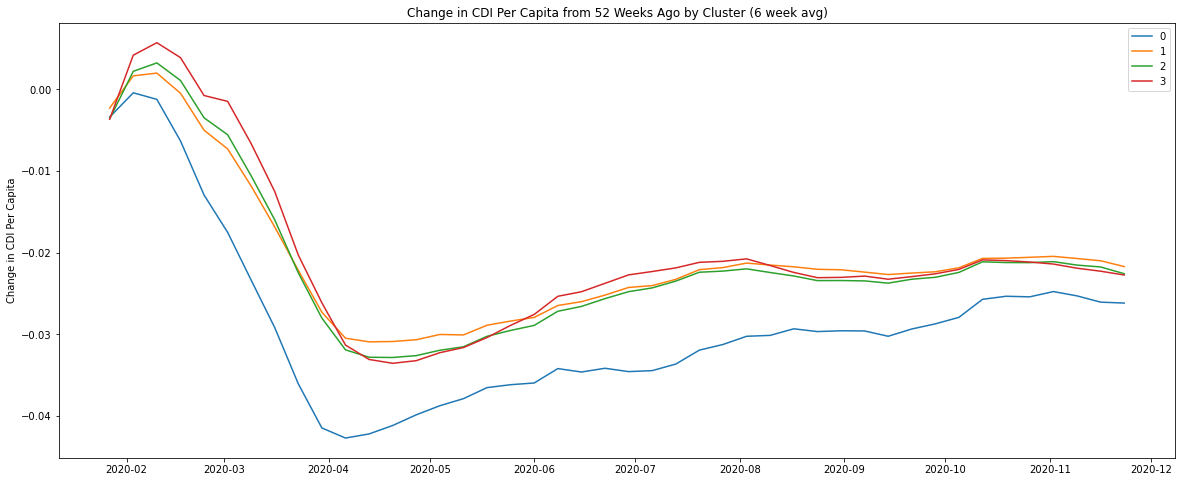

In [78]:
fig, ax = plt.subplots(figsize=(20, 8))
for key, group in cdi_cluster_diff_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title(
    'Change in CDI Per Capita from 52 Weeks Ago by Cluster (6 week avg)')
ax.set_ylabel('Change in CDI Per Capita')
ax.legend()
plt.show()

In [80]:
cdi_cbg_df = merge_df.groupby(by=['date_range_start', 'cbg']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_cbg_df = cdi_cbg_df.merge(cbg_df, how='outer', on=['cbg'])
cdi_cbg_df = cdi_cbg_df.sort_values(by=['date_range_start', 'cbg'])
cdi_cbg_df[
    'cdi_per_capita'] = cdi_cbg_df['cdi'] / cdi_cbg_df['population']

In [81]:
cdi_cbg_df

,date_range_start,cbg,cdi,cluster,population,cdi_per_capita
0,2019-01-07 00:00:00-05:00,360050001001,156.826608,3,6864.0,0.022848
98,2019-01-07 00:00:00-05:00,360050002001,41.926304,3,1744.0,0.024040
200,2019-01-07 00:00:00-05:00,360050002002,64.292530,2,1569.0,0.040977
302,2019-01-07 00:00:00-05:00,360050002003,84.304776,1,1219.0,0.069159
404,2019-01-07 00:00:00-05:00,360050004001,16.703557,1,598.0,0.027932
...,...,...,...,...,...,...
630192,2020-12-28 00:00:00-05:00,360850319012,15.289446,2,1223.0,0.012502
630294,2020-12-28 00:00:00-05:00,360850319021,27.782982,3,1731.0,0.016050
630396,2020-12-28 00:00:00-05:00,360850319022,19.577289,2,1667.0,0.011744
630498,2020-12-28 00:00:00-05:00,360850319023,22.039937,2,1945.0,0.011332


In [82]:
cdi_cbg_df = cdi_cbg_df.rename(columns={'home_cbg': 'cbg'})
cdi_cbg_diff_df = create_diff_df(cdi_cbg_df,
                                     diff_columns=['cdi', 'cdi_per_capita'],
                                     keep_columns=['cbg'])
cdi_cbg_diff_2020_df = cdi_cbg_diff_df.groupby(by=['cbg']).agg({'cdi': 'sum'})
cdi_cbg_diff_2020_df.head()

,date_range_start,cbg,cdi,cluster,population,cdi_per_capita,year,week
9656,2019-01-07 00:00:00-05:00,360050056001,34.118243,3,956.0,0.035689,2019,2
9758,2019-01-07 00:00:00-05:00,360050056002,30.050199,3,601.0,0.050000,2019,2
9860,2019-01-07 00:00:00-05:00,360050056003,28.173190,2,722.0,0.039021,2019,2
9962,2019-01-07 00:00:00-05:00,360050059021,232.064890,3,866.0,0.267973,2019,2
10064,2019-01-07 00:00:00-05:00,360050059022,65.762952,3,1885.0,0.034888,2019,2
10166,2019-01-07 00:00:00-05:00,360050060001,31.719555,3,1386.0,0.022886,2019,2
10268,2019-01-07 00:00:00-05:00,360050061002,202.364947,0,3720.0,0.054399,2019,2
10370,2019-01-07 00:00:00-05:00,360050062001,48.494439,3,1092.0,0.044409,2019,2
10472,2019-01-07 00:00:00-05:00,360050062002,54.905976,3,1446.0,0.037971,2019,2
10574,2019-01-07 00:00:00-05:00,360050062003,66.198155,3,2608.0,0.025383,2019,2


,date_range_start,cbg,cdi,cluster,population,cdi_per_capita,year,week
0,2019-01-07 00:00:00-05:00,360050001001,156.826608,3,6864.0,0.022848,2019,2
1,2019-01-07 00:00:00-05:00,360050002001,41.926304,3,1744.0,0.024040,2019,2
2,2019-01-07 00:00:00-05:00,360050002002,64.292530,2,1569.0,0.040977,2019,2
3,2019-01-07 00:00:00-05:00,360050002003,84.304776,1,1219.0,0.069159,2019,2
4,2019-01-07 00:00:00-05:00,360050004001,16.703557,1,598.0,0.027932,2019,2


,date_range_start,cbg,cdi,cluster,population,cdi_per_capita,year,week
0,2020-01-06 00:00:00-05:00,360050001001,209.389274,3,6864.0,0.030505,2020,2
1,2020-01-06 00:00:00-05:00,360050002001,70.837399,3,1744.0,0.040618,2020,2
2,2020-01-06 00:00:00-05:00,360050002002,105.865440,2,1569.0,0.067473,2020,2
3,2020-01-06 00:00:00-05:00,360050002003,79.903352,1,1219.0,0.065548,2020,2
4,2020-01-06 00:00:00-05:00,360050004001,42.504528,1,598.0,0.071078,2020,2


,cbg,week,date_range_start,cdi,cdi_per_capita
0,360050001001,2,2020-01-06 00:00:00-05:00,52.562666,0.007658
1,360050002001,2,2020-01-06 00:00:00-05:00,28.911095,0.016577
2,360050002002,2,2020-01-06 00:00:00-05:00,41.572910,0.026496
3,360050002003,2,2020-01-06 00:00:00-05:00,-4.401424,-0.003611
4,360050004001,2,2020-01-06 00:00:00-05:00,25.800972,0.043145


,cdi
cbg,
360050001001,-136.002504
360050002001,-1116.209189
360050002002,-741.862396
360050002003,-1715.217374
360050004001,-2093.370751


In [83]:
cdi_cbg_diff_2020_df.to_csv('./exports/cdi/cbg_diff_2020.csv', index=False)